# Beta Binomial

Evaluate estimates distributions using Dirichlet-Multinomial

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import multiprocessing
from sklearn.utils import check_array

import mmur
import mmu
from mmu import DirichletMultinomialConfusionMatrix
from mmu.metrics import confusion_matrix_proba
from mmu.metrics import binary_metrics_runs
from mmu.metrics import binary_metrics_confusion

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.max_open_warning'] = 0
COLORS = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

<IPython.core.display.Javascript object>

In [4]:
def plot_metric_distributions(estimated_metrics, gt_metrics, coverage=None):
    fig, axs = plt.subplots(ncols=5, figsize=(25, 5))
    for i, c in enumerate(estimated_metrics.columns):
        sns.kdeplot(estimated_metrics[c], ax=axs[i], label='estimated')
        if coverage is not None:
            sns.kdeplot(coverage[c], ax=axs[i], label='simulated')
        axs[i].axvline(gt_metrics[c][0], c='grey', lw=2, ls='--', label='population mean')
    axs[0].legend()
    return fig, axs

<IPython.core.display.Javascript object>

In [5]:
target_metrics = [
    'neg.precision', 'pos.precision', 'neg.recall', 'pos.recall', 'mcc'
]

<IPython.core.display.Javascript object>

## Generate data

Generate data from a Logistic process with noise

#### Hold-out set

Validate the model by comparing the credible interval of the samples from the model and unseen data sampled from the data generating process.

In [6]:
generator = mmur.LogisticGenerator()
outp = generator.fit_transform(
    train_samples=10000,
    test_samples=10000,
    holdout_samples=10000,
    noise_sigma=0.3,
    enable_noise=True,
    random_state=123456
)

<IPython.core.display.Javascript object>

Select the test sets

In [7]:
y_test = outp['test']['y']
probas_test = outp['test']['proba']

<IPython.core.display.Javascript object>

Compute the confusion matrix on the test-set

In [8]:
test_conf_mat, test_metrics = mmu.binary_metrics_proba(
    y_test, probas_test, threshold=0.5
)
test_conf_mat = test_conf_mat.flatten()
test_metrics = mmu.metrics_to_dataframe(test_metrics)[target_metrics]

<IPython.core.display.Javascript object>

In [9]:
mmu.confusion_matrix_to_dataframe(test_conf_mat)

estimated         
                   negative positive
observed negative      4443      295
         positive       289     4973

<IPython.core.display.Javascript object>

In [10]:
test_metrics

,neg.precision,pos.precision,neg.recall,pos.recall,mcc
0,0.938926,0.944002,0.937737,0.945078,0.882872


<IPython.core.display.Javascript object>

In [11]:
test_conf_mat

array([4443,  295,  289, 4973])

<IPython.core.display.Javascript object>

### Ground truth

In [12]:
gt_proba_test = outp['ground_truth']['test']

<IPython.core.display.Javascript object>

Compute the ground truth confusion matrix and metrics

In [13]:
gt_conf_mat, gt_metrics = mmu.binary_metrics_proba(
    y_test, gt_proba_test, threshold=0.5
)

<IPython.core.display.Javascript object>

In [14]:
gt_confusion_matrix = mmu.confusion_matrix_to_dataframe(gt_conf_mat)
gt_confusion_matrix

estimated         
                   negative positive
observed negative      4440      298
         positive       288     4974

<IPython.core.display.Javascript object>

In [15]:
gt_metrics = mmu.metrics_to_dataframe(gt_metrics)[target_metrics]
gt_metrics

,neg.precision,pos.precision,neg.recall,pos.recall,mcc
0,0.939086,0.943475,0.937104,0.945268,0.882467


<IPython.core.display.Javascript object>

### Hold-out set

In [16]:
y_holdout = outp['holdout']['y']
proba_holdout = outp['holdout']['proba']

<IPython.core.display.Javascript object>

Compute metrics on this set

In [17]:
# holdout_conf_mat, holdout_metrics = mmu.binary_metrics_runs_thresholds(
#     y=y_holdout, proba=proba_holdout, thresholds=np.array((0.5, ))
# )
# holdout_metrics = mmu.metrics_to_dataframe(holdout_metrics)[target_metrics]

<IPython.core.display.Javascript object>

# Model data and params

In [18]:
# random_state = 42
# n_samples=10000
# n_warmup=500
# threshold=0.5
# n_chains =2

params = {
    'random_state': 42,
    'n_samples': 10000,
    'n_warmup': 500,
    'threshold': 0.5,
    'n_chains': 2,
}

<IPython.core.display.Javascript object>

In [19]:
X = test_conf_mat

total_count = int(X.sum())

data = {
'n': total_count,
'y': X.flatten(),
'tpr_prior': np.ones(2),
'tnr_prior': np.ones(2),
'phi_prior': np.ones(2),
}

<IPython.core.display.Javascript object>

## Stan Model

In [20]:
import stan
from mmur.stan import _bnn_code

<IPython.core.display.Javascript object>

In [21]:
def run_stan(data_dict, params_dict):
    
    # specific stan params
    _gen = np.random.default_rng(params_dict['random_state'])

    model = stan.build(
        _bnn_code,
        data=data,
        random_seed=int(params_dict['random_state'])
    )

    fit_ = model.sample(
        num_warmup= params_dict['n_warmup'],
        num_samples=params_dict['n_samples'],
        num_chains=params_dict['n_chains']
    )
    
    
    fit_data_ = az.from_pystan(
        posterior=fit_,
        posterior_predictive=['y_hat'],
        observed_data=list(data.keys()),
        posterior_model=model
    )

    # validate if enough non-divergent samples were drawn
    div_mask = fit_data_.sample_stats.get('diverging').values
    n_samples_drawn = div_mask.size
    n_non_divergent = n_samples_drawn - div_mask.sum()
    if n_non_divergent < params_dict['n_samples']*params_dict['n_chains']:
        m = (
            f'The number of non-divergent samples ({n_non_divergent}) is'
            ' smaller than the requested samples ({n_samples}).'
            ' You should increase the sample factor.'
        )
        raise RuntimeError(m)
    
    # generative samples
    y_hat = (
        fit_data_
        .posterior_predictive
        .get('y_hat')
        .values
        [~div_mask]
    )

    # subsample the posterior samples
    sidx = _gen.choice(
        np.arange(n_non_divergent),
        replace=False,
        size=params_dict['n_samples']
    )

    sample_conf_mats_ = np.asarray(y_hat[sidx], dtype=np.int64, order='C')
    
    # stan takes up all the memory so let's delete after use
    del fit_data_
    del y_hat
    del sidx
    
    return sample_conf_mats_.T

<IPython.core.display.Javascript object>

In [22]:
# y = run_stan(data, params)

<IPython.core.display.Javascript object>

In [23]:
# gt_vals = gt_confusion_matrix.values.flatten()

# fig, axes = plt.subplots(2,2, figsize=(8,8))
# axes = axes.ravel()
# for i, _ in enumerate(axes):
    
#     sampled_vals =y[i]
#     hist_outputs = axes[i].hist(sampled_vals, bins=200)
#     axes[i].vlines(gt_vals[i], 0, 1.01*max(hist_outputs[0]), color='blue', label='true')

# plt.show()

<IPython.core.display.Javascript object>

# Numpyro

In [24]:

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random, vmap

/Users/jasonmyers/opt/miniconda3/envs/mmu/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/Users/jasonmyers/opt/miniconda3/envs/mmu/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


<IPython.core.display.Javascript object>

In [25]:
def run_numpyro(data, params):
    
    numpyro.set_host_device_count(2)
    
    def model(tpr_prior, tnr_prior, phi_prior, n, y=None, ):
    
        phi = numpyro.sample("phi", dist.Beta(phi_prior[0], phi_prior[1]))
        tpr = numpyro.sample("tpr", dist.Beta(tpr_prior[0], tpr_prior[1]))
        tnr = numpyro.sample("tnr", dist.Beta(tnr_prior[0], tnr_prior[1]))

        theta_tp = phi * tpr
        theta_tn = (1-phi) * tnr
        theta_fn = phi * (1-tpr)
        theta_fp = (1-phi) * (1-tnr)

        y0, y1, y2, y3 = y if y is not None else [None, None, None, None]

        numpyro.sample("y0", dist.Binomial(n, theta_tp), obs=y0)
        numpyro.sample("y1", dist.Binomial(n, theta_tn), obs=y1)
        numpyro.sample("y2", dist.Binomial(n, theta_fn), obs=y2)
        numpyro.sample("y3", dist.Binomial(n, theta_fp), obs=y3)
    
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(params['random_state'])
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel, 
        num_chains=params['n_chains'], 
        num_warmup=params['n_warmup'], 
        num_samples=params['n_samples']
    )
    mcmc.run(
        rng_key_, 
        n=data['n'], 
        y=data['y'], 
        tpr_prior=data['tpr_prior'], 
        tnr_prior=data['tnr_prior'], 
        phi_prior=data['phi_prior']
    )
    mcmc.print_summary()
    samples = mcmc.get_samples()
    
    
    predictive = Predictive(model, posterior_samples=samples)
    
    output_pred = predictive(
        rng_key_, 
        n=data['n'], 
        tpr_prior=data['tpr_prior'], 
        tnr_prior=data['tnr_prior'], 
        phi_prior=data['phi_prior']
    )
    
    return [np.array(vals) for vals in output_pred.values()]

<IPython.core.display.Javascript object>

In [26]:
# y = run_numpyro(data, params)

<IPython.core.display.Javascript object>

In [27]:
# gt_vals = gt_confusion_matrix.values.flatten()

# fig, axes = plt.subplots(2,2, figsize=(8,8))
# axes = axes.ravel()
# for i, _ in enumerate(axes):
    
#     sampled_vals = np.array(output_pred[f'y{i}'])
#     hist_outputs = axes[i].hist(sampled_vals, bins=200)
#     axes[i].vlines(gt_vals[i], 0, 1.01*max(hist_outputs[0]), color='blue', label='true')

# plt.show()

<IPython.core.display.Javascript object>

# tensor flow probability

In [28]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

<IPython.core.display.Javascript object>

In [29]:
def run_tensorflowprob(data, params):
    
    def build_model():
        # Prior Distribution.
        tpr = tfd.Beta(
          concentration1=data['tpr_prior'][0], concentration0=data['tpr_prior'][1]
        )
        tnr = tfd.Beta(
          concentration1=data['tnr_prior'][0], concentration0=data['tnr_prior'][1]
        )
        phi = tfd.Beta(
          concentration1=data['phi_prior'][0], concentration0=data['phi_prior'][1]
        )
        # Likelihood: Independent samples of a Poisson distribution. 
        y0 = lambda phi, tpr: tfd.Binomial(total_count=data['n'], probs=phi * tpr)
        y1 = lambda phi, tnr: tfd.Binomial(total_count=data['n'], probs=(1-phi) * tnr)
        y2 = lambda phi, tpr: tfd.Binomial(total_count=data['n'], probs=phi * (1-tpr))
        y3 = lambda phi, tnr: tfd.Binomial(total_count=data['n'], probs=(1-phi) * (1-tnr))

        return tfd.JointDistributionNamed(dict(phi=phi, tnr=tnr, tpr=tpr, y0=y0, y1=y1, y2=y2, y3=y3))

    def target_log_prob_fn(phi, tnr, tpr):
        model = build_model()
        return model.log_prob(
            phi=phi, tnr=tnr, tpr=tpr, y0=data['y'][0], y1=data['y'][1], y2=data['y'][2], y3=data['y'][3]
        )
    
    
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob_fn, step_size=0.1,
    )

    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = kernel,
        num_adaptation_steps=int(params['n_warmup'] * 0.8)
    )
    
    init_state = [
        tf.convert_to_tensor([0.9], dtype='float64'), 
        tf.convert_to_tensor([0.9], dtype='float64'),
        tf.convert_to_tensor([0.9], dtype='float64')
    ]
    
    @tf.function
    def do_sampling():
        samples, acceptance = tfp.mcmc.sample_chain(
            num_results=params['n_samples'],
            num_burnin_steps=params['n_warmup'],
            current_state=init_state,
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
        )
        print(f'acceptance for chain is {acceptance}')
        return samples

    states = [do_sampling() for _ in range(params['n_chains'])]
    states_concat = tf.concat(states, 1)
    
    # generative sampling
    phi_post=states_concat[0]
    tnr_post=states_concat[1]
    tpr_post=states_concat[2]

    y0 = tfd.Binomial(total_count=data['n'], probs=phi_post * tpr_post)
    y1 = tfd.Binomial(total_count=data['n'], probs=(1-phi_post) * tnr_post)
    y2 = tfd.Binomial(total_count=data['n'], probs=phi_post * (1-tpr_post))
    y3 = tfd.Binomial(total_count=data['n'], probs=(1-phi_post) * (1-tnr_post))

    y = [
        y0.sample().numpy(), 
        y1.sample().numpy(), 
        y2.sample().numpy(), 
        y3.sample().numpy()
    ]
    
    return y

<IPython.core.display.Javascript object>

In [30]:
# y = run_tensorflowprob(data, params)

<IPython.core.display.Javascript object>

In [31]:
# gt_vals = gt_confusion_matrix.values.flatten()

# fig, axes = plt.subplots(2,2, figsize=(8,8))
# axes = axes.ravel()
# for i, _ in enumerate(axes):
    
#     sampled_vals = y[i].sample().numpy()
#     hist_outputs = axes[i].hist(sampled_vals, bins=200)
#     axes[i].vlines(gt_vals[i], 0, 1.01*max(hist_outputs[0]), color='blue', label='true')

# plt.show()

<IPython.core.display.Javascript object>

Poduced unhelpful error messages that made any debugging work challenging. In all honesty the entire infrastructure is not great and would strongly recomend not using this package for Bayesian modelling untill more work has been done. 

# PyMC3

In [32]:
import pymc3 as pm
import theano.tensor as tt

<IPython.core.display.Javascript object>

In [33]:
def run_pymc3(data, params):
    y0, y1, y2, y3 = data['y'] 
    n = data['n']

    with pm.Model() as pmmodel:

        phi = pm.Beta('phi', data['phi_prior'][0], data['phi_prior'][1])
        tpr = pm.Beta('tpr', data['tpr_prior'][0], data['tpr_prior'][1])
        tnr = pm.Beta('tnr', data['tnr_prior'][0], data['tnr_prior'][1])

        theta_tp = phi * tpr
        theta_tn = (1-phi) * tnr
        theta_fn = phi * (1-tpr)
        theta_fp = (1-phi) * (1-tnr)

        y0 = pm.Binomial("y0", n=n, p=theta_tp, observed=y0)
        y1 = pm.Binomial("y1", n=n, p=theta_tn, observed=y1)
        y2 = pm.Binomial("y2", n=n, p=theta_fn, observed=y2)
        y3 = pm.Binomial("y3", n=n, p=theta_fp, observed=y3)
    
    with pmmodel:
        trace = pm.sample(
            params['n_samples'], 
            tune=params['n_warmup'], 
            chains=params['n_chains'], 
            target_accept=0.95, 
            return_inferencedata=True
        )

        # check convergence diagnostics
        assert all(az.rhat(trace) < 1.03)
        
    phi_post=trace['posterior']['phi'].values.flatten()
    tnr_post=trace['posterior']['tnr'].values.flatten()
    tpr_post=trace['posterior']['tpr'].values.flatten()

    y0 = np.random.binomial(data['n'], phi_post * tpr_post)
    y1 = np.random.binomial(data['n'], (1-phi_post) * tnr_post)
    y2 = np.random.binomial(data['n'], phi_post * (1-tpr_post))
    y3 = np.random.binomial(data['n'], (1-phi_post) * (1-tnr_post))

    y = [y0, y1, y2, y3]
    
    return y


<IPython.core.display.Javascript object>

In [34]:
# y = run_pymc3(data, params)

<IPython.core.display.Javascript object>

In [35]:
# gt_vals = gt_confusion_matrix.values.flatten()

# fig, axes = plt.subplots(2,2, figsize=(8,8))
# axes = axes.ravel()
# for i, _ in enumerate(axes):
    
#     sampled_vals = y[i]
#     hist_outputs = axes[i].hist(sampled_vals, bins=200)
#     axes[i].vlines(gt_vals[i], 0, 1.01*max(hist_outputs[0]), color='blue', label='true')

# plt.show()

<IPython.core.display.Javascript object>

# comparisons

In [36]:
y_stan = run_stan(data, params)

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  50% (10500/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


<IPython.core.display.Javascript object>

In [37]:
y_numpyro = run_numpyro(data, params)

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       phi      0.47      0.00      0.47      0.47      0.48  21537.10      1.00
       tnr      0.06      0.00      0.06      0.05      0.06  16054.61      1.00
       tpr      0.94      0.00      0.94      0.93      0.94  22241.94      1.00

Number of divergences: 0


<IPython.core.display.Javascript object>

In [38]:
y_tf = run_tensorflowprob(data, params)

acceptance for chain is Tensor("mcmc_sample_chain/trace_scan/TensorArrayV2Stack_3/TensorListStack:0", shape=(10000, 1), dtype=bool)


<IPython.core.display.Javascript object>

In [39]:
y_pymc3 = run_pymc3(data, params)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tnr, tpr, phi]
INFO:pymc3:NUTS: [tnr, tpr, phi]


Sampling 2 chains for 500 tune and 10_000 draw iterations (1_000 + 20_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 2 chains for 500 tune and 10_000 draw iterations (1_000 + 20_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

In [43]:
generated_data_dict = {
    'y_stan' : y_stan,
    'y_numpyro' : y_numpyro,
    'y_tf' : y_tf,
    'y_pymc3' : y_pymc3 ,
}

<IPython.core.display.Javascript object>

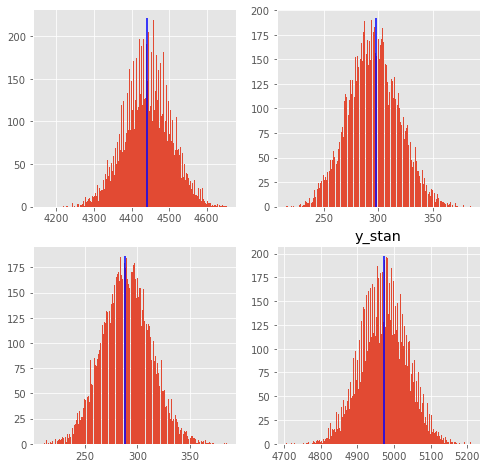

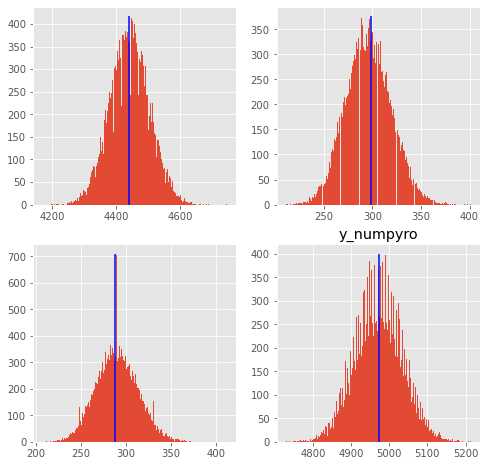

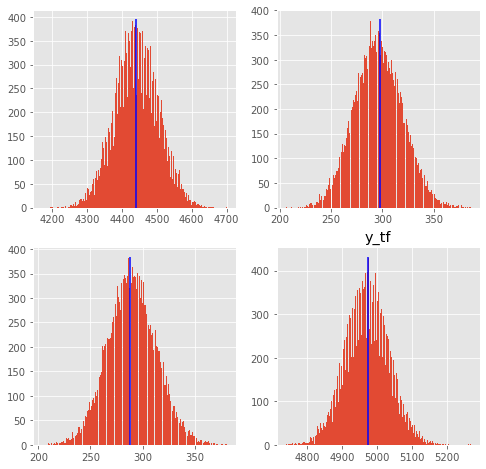

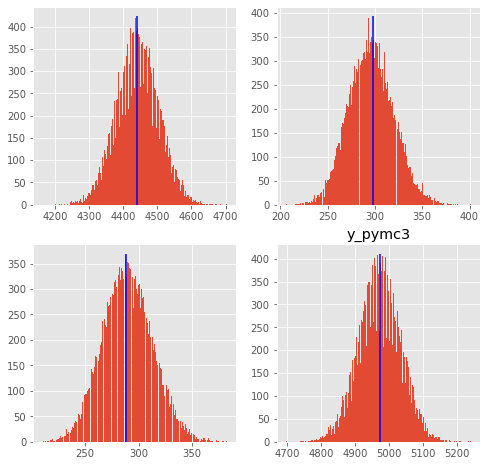

<IPython.core.display.Javascript object>

In [45]:
gt_vals = gt_confusion_matrix.values.flatten()

for name, y in generated_data_dict.items():

    fig, axes = plt.subplots(2,2, figsize=(8,8))
    axes = axes.ravel()
    for i, _ in enumerate(axes):

        sampled_vals = y[i]
        hist_outputs = axes[i].hist(sampled_vals, bins=200)
        axes[i].vlines(gt_vals[i], 0, 1.01*max(hist_outputs[0]), color='blue', label='true')
    plt.title(name)
    plt.show()
    
    print('\n')

# Summray of learnings

I found a good blog post (https://towardsdatascience.com/3-probabilistic-frameworks-you-should-know-the-bayesian-toolkit-c13fe7c4b12e) that roughly sums up the game here:

* Stan is the staticians choice.

* Pyro/Numpyro is the programming choice

* Tensorflow probability - the googlers

* PyMC3 got an honourable mention. 

My learnings. 

Stan is the standard and hard to beat. Best documentation and large community of people makes this much easier and simple to use. The downside is the code must be written in as a string for python feels a little odd and also means a newcomer needs to get comfortable with Stan, not that this is a complex language by any means

I liked Numpyro for its more native python feel. In fairness PyMC3 was very similar but I couldn't find any nice functionality for PyMC3 inference stage having to generate outputs using numpy - this is not bad just a little weird somehow. Numpyro is a work in progress and gave some slightly worrying errors that some of its Jax dependeences were out of date. The main difference between pyro and numpyro is the back end of the latter is in Jax to give is a numpy feel whilst the former makes use of pytorch. 

Since I stared on PyMC3 I notice that it feels a lot slower than the other three options here. Also seemingly not that natural to perform inference within PyMC3 and ended up using numpy random using the posterior of the model parameters.

Finally TensorFlow probability - each of the other three took me about 30 min to an hour to get working correctly. This took all day. Documentation is not clear and this is by far the most complex of the choices. It is quite verbose. Some seem to prefer the verbosity but makes it tough to start up on this and non-intuitive. Presumably if one wanted to do something in TensorFlow then this becomes good but as it stands would not reccomend outside of this fringe case. Worth noting that I tried to use the NUTS solver but its still in experiementation phase. Unfortuantly error messages made this near impossible to debug. Also seemingly doesn't naturally allow for inference and must be performed as a seperate step based on the posterior of the model parameters. 


For what it is worth I think that variational inference would be easeir in Pyro/Numpyroo than stan, although still possible in the later it is not as natural. 